In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

resultsPath = Path("../results/OpenMP_3.csv")

In [16]:
dataFrame = pd.read_csv(resultsPath)
dataFrame["numIntervals"] = dataFrame["numIntervals"].astype(int)
dataFrame["numThreads"] = dataFrame["numThreads"].astype(int)
dataFrame["timeSeconds"] = dataFrame["timeSeconds"].astype(float)
dataFrame["runIndex"] = dataFrame["runIndex"].astype(int)

print("Loaded rows:", len(dataFrame))
print("Modes:", dataFrame["mode"].unique())
print("Problem sizes (numIntervals):", sorted(dataFrame["numIntervals"].unique()))
print("Thread counts:", sorted(dataFrame["numThreads"].unique()))
dataFrame.head(8)

Loaded rows: 320
Modes: ['reduction' 'no_reduction']
Problem sizes (numIntervals): [1000000, 5000000, 10000000, 50000000]
Thread counts: [1, 2, 4, 6, 8, 16, 32, 64]


,testType,numIntervals,numThreads,mode,timeSeconds,integralValue,runIndex,ompEnv
0,OpenMP_3,1000000,1,reduction,0.026977,2,1,OMP_NUM_THREADS=1
1,OpenMP_3,1000000,1,reduction,0.027561,2,2,OMP_NUM_THREADS=1
2,OpenMP_3,1000000,1,reduction,0.026866,2,3,OMP_NUM_THREADS=1
3,OpenMP_3,1000000,1,reduction,0.026904,2,4,OMP_NUM_THREADS=1
4,OpenMP_3,1000000,1,reduction,0.027365,2,5,OMP_NUM_THREADS=1
5,OpenMP_3,1000000,2,reduction,0.015281,2,1,OMP_NUM_THREADS=2
6,OpenMP_3,1000000,2,reduction,0.014208,2,2,OMP_NUM_THREADS=2
7,OpenMP_3,1000000,2,reduction,0.014576,2,3,OMP_NUM_THREADS=2


In [17]:
groupedFrame = dataFrame.groupby(["mode","numIntervals","numThreads"], as_index=False).agg(
    median=("timeSeconds","median"),
    mean=("timeSeconds","mean"),
    std=("timeSeconds","std"),
    count=("timeSeconds","count")
)
groupedFrame["std"] = groupedFrame["std"].fillna(0.0)
groupedFrame = groupedFrame.sort_values(["mode","numIntervals","numThreads"]).reset_index(drop=True)
groupedFrame.head(12)

,mode,numIntervals,numThreads,median,mean,std,count
0,no_reduction,1000000,1,0.027138,0.027194,0.000384,5
1,no_reduction,1000000,2,0.014205,0.014431,0.000509,5
2,no_reduction,1000000,4,0.011218,0.011099,0.000536,5
3,no_reduction,1000000,6,0.007823,0.007620,0.000359,5
4,no_reduction,1000000,8,0.006018,0.005858,0.000444,5
5,no_reduction,1000000,16,0.005069,0.005113,0.000140,5
6,no_reduction,1000000,32,0.004679,0.004744,0.000199,5
7,no_reduction,1000000,64,0.005404,0.005417,0.000184,5
8,no_reduction,5000000,1,0.136619,0.136565,0.001019,5
9,no_reduction,5000000,2,0.069159,0.069978,0.001642,5


In [18]:
def computeSpeedupEfficiency(groupedDf):
    frames = []
    for (modeVal, numIntervalsVal), subFrame in groupedDf.groupby(["mode","numIntervals"]):
        baseRows = subFrame[subFrame["numThreads"] == 1]
        if baseRows.empty:
            continue
        baseTime = float(baseRows["median"].values[0])
        subFrame = subFrame.copy()
        subFrame["speedup"] = baseTime / subFrame["median"]
        subFrame["efficiency"] = subFrame["speedup"] / subFrame["numThreads"]
        frames.append(subFrame)
    return pd.concat(frames, ignore_index=True)

perfFrame = computeSpeedupEfficiency(groupedFrame)
perfFrame.head(12)

,mode,numIntervals,numThreads,median,mean,std,count,speedup,efficiency
0,no_reduction,1000000,1,0.027138,0.027194,0.000384,5,1.000000,1.000000
1,no_reduction,1000000,2,0.014205,0.014431,0.000509,5,1.910441,0.955220
2,no_reduction,1000000,4,0.011218,0.011099,0.000536,5,2.419126,0.604782
3,no_reduction,1000000,6,0.007823,0.007620,0.000359,5,3.469090,0.578182
4,no_reduction,1000000,8,0.006018,0.005858,0.000444,5,4.509547,0.563693
5,no_reduction,1000000,16,0.005069,0.005113,0.000140,5,5.353507,0.334594
6,no_reduction,1000000,32,0.004679,0.004744,0.000199,5,5.800577,0.181268
7,no_reduction,1000000,64,0.005404,0.005417,0.000184,5,5.022300,0.078473
8,no_reduction,5000000,1,0.136619,0.136565,0.001019,5,1.000000,1.000000
9,no_reduction,5000000,2,0.069159,0.069978,0.001642,5,1.975431,0.987715


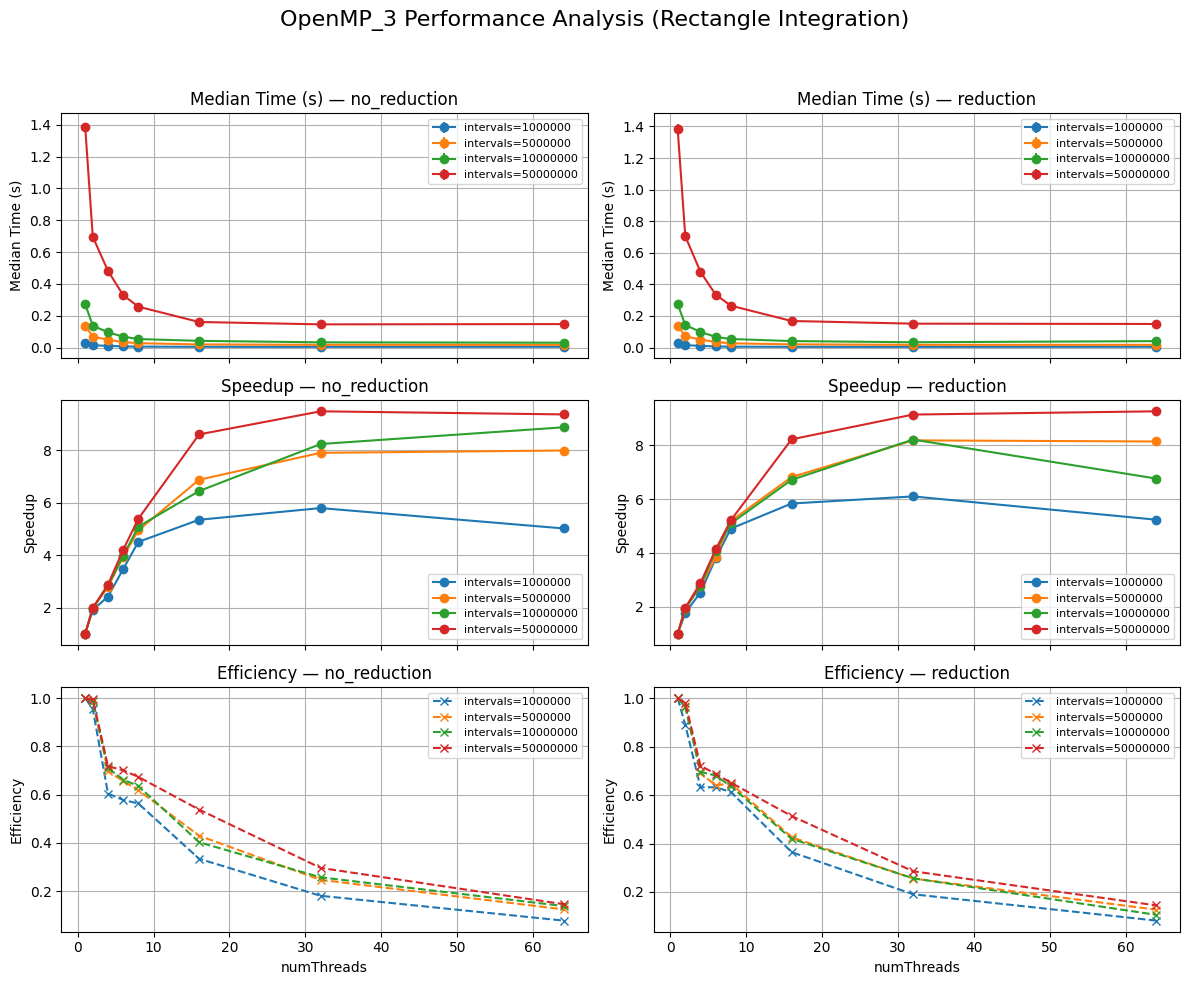

In [19]:
modes = sorted(perfFrame["mode"].unique())
metrics = ["median", "speedup", "efficiency"]
metricLabels = {
    "median": "Median Time (s)",
    "speedup": "Speedup",
    "efficiency": "Efficiency"
}
fig, axes = plt.subplots(3, 2, figsize=(12, 10), sharex=True)
axes = axes.flatten()
for colIdx, modeVal in enumerate(modes):
    for rowIdx, metric in enumerate(metrics):
        axIdx = rowIdx*2 + colIdx
        ax = axes[axIdx]
        for numIntervalsVal in sorted(perfFrame["numIntervals"].unique()):
            subFrame = perfFrame[(perfFrame["mode"]==modeVal) & (perfFrame["numIntervals"]==numIntervalsVal)].sort_values("numThreads")
            if subFrame.empty:
                continue
            x = subFrame["numThreads"].values
            y = subFrame[metric].values
            if metric == "median":
                yerr = subFrame["std"].values
                ax.errorbar(x, y, yerr=yerr, marker='o', linestyle='-', label=f"intervals={numIntervalsVal}")
            else:
                markerStyle = 'o' if metric == "speedup" else 'x'
                linestyle = '-' if metric == "speedup" else '--'
                ax.plot(x, y, marker=markerStyle, linestyle=linestyle, label=f"intervals={numIntervalsVal}")
        ax.set_title(f"{metricLabels[metric]} — {modeVal}")
        if rowIdx == 2:
            ax.set_xlabel("numThreads")
        ax.set_ylabel(metricLabels[metric])
        ax.grid(True)
        ax.legend(fontsize=8)
plt.suptitle("OpenMP_3 Performance Analysis (Rectangle Integration)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [20]:
for modeVal in perfFrame["mode"].unique():
    pivotTime = perfFrame[perfFrame["mode"]==modeVal].pivot(index="numThreads", columns="numIntervals", values="median")
    pivotSpeedup = perfFrame[perfFrame["mode"]==modeVal].pivot(index="numThreads", columns="numIntervals", values="speedup")
    print(f"\n=== mode: {modeVal} — median time (s) ===")
    display(pivotTime)
    print(f"\n=== mode: {modeVal} — speedup ===")
    display(pivotSpeedup)


=== mode: no_reduction — median time (s) ===


numIntervals,1000000,5000000,10000000,50000000
numThreads,,,,
1,0.027138,0.136619,0.272964,1.386450
2,0.014205,0.069159,0.138202,0.696151
4,0.011218,0.048995,0.095978,0.482322
6,0.007823,0.034666,0.068693,0.329676
8,0.006018,0.027603,0.053620,0.257163
16,0.005069,0.019851,0.042318,0.160947
32,0.004679,0.017270,0.033099,0.145997
64,0.005404,0.017079,0.030718,0.147836



=== mode: no_reduction — speedup ===


numIntervals,1000000,5000000,10000000,50000000
numThreads,,,,
1,1.000000,1.000000,1.000000,1.000000
2,1.910441,1.975431,1.975109,1.991594
4,2.419126,2.788427,2.844012,2.874532
6,3.469090,3.941020,3.973663,4.205493
8,4.509547,4.949480,5.090750,5.391328
16,5.353507,6.882396,6.450320,8.614326
32,5.800577,7.910908,8.247020,9.496428
64,5.022300,7.999239,8.886039,9.378298



=== mode: reduction — median time (s) ===


numIntervals,1000000,5000000,10000000,50000000
numThreads,,,,
1,0.026977,0.138593,0.275357,1.381760
2,0.015163,0.071654,0.142658,0.704439
4,0.010667,0.050142,0.098921,0.479062
6,0.007110,0.036096,0.067448,0.334872
8,0.005505,0.026746,0.054070,0.265161
16,0.004625,0.020341,0.041037,0.168212
32,0.004425,0.016952,0.033556,0.151281
64,0.005156,0.017038,0.040737,0.149317



=== mode: reduction — speedup ===


numIntervals,1000000,5000000,10000000,50000000
numThreads,,,,
1,1.000000,1.000000,1.000000,1.000000
2,1.779161,1.934187,1.930190,1.961504
4,2.528915,2.764010,2.783599,2.884303
6,3.794351,3.839524,4.082532,4.126233
8,4.900133,5.181725,5.092621,5.211023
16,5.832674,6.813547,6.710034,8.214396
32,6.095741,8.175372,8.205870,9.133731
64,5.232504,8.134442,6.759433,9.253869


In [21]:
summaryRows = []
for (modeVal, numIntervalsVal), sub in perfFrame.groupby(["mode","numIntervals"]):
    maxSpeedup = sub["speedup"].max()
    argMax = sub.loc[sub["speedup"].idxmax()]
    bestThreads = int(argMax["numThreads"])
    effAtBest = float(argMax["efficiency"])
    medianAtOne = sub.loc[sub["numThreads"]==1, "median"]
    medianAtOne = float(medianAtOne.values[0]) if not medianAtOne.empty else np.nan
    summaryRows.append({
        "mode": modeVal,
        "numIntervals": numIntervalsVal,
        "bestNumThreads": bestThreads,
        "maxSpeedup": maxSpeedup,
        "efficiencyAtBest": effAtBest,
        "medianTime1Thread": medianAtOne
    })
summaryAnalysisFrame = pd.DataFrame(summaryRows).sort_values(["mode","numIntervals"])
display(summaryAnalysisFrame)


,mode,numIntervals,bestNumThreads,maxSpeedup,efficiencyAtBest,medianTime1Thread
0,no_reduction,1000000,32,5.800577,0.181268,0.027138
1,no_reduction,5000000,64,7.999239,0.124988,0.136619
2,no_reduction,10000000,64,8.886039,0.138844,0.272964
3,no_reduction,50000000,32,9.496428,0.296763,1.386450
4,reduction,1000000,32,6.095741,0.190492,0.026977
5,reduction,5000000,32,8.175372,0.255480,0.138593
6,reduction,10000000,32,8.205870,0.256433,0.275357
7,reduction,50000000,64,9.253869,0.144592,1.381760
